# Re-weighting

OpenFisca-UK primarily relies on the Family Resources Survey, which has known issues with non-capture of households at the bottom and top of the income distribution. To correct for this, we apply a weight modification, optimised using gradient descent to minimise survey error against a diverse selection of targeting statistics. These include:

* Country-level program statistics
* Regional populations
* Tax revenues by income range
* Taxpayer counts by tax band
* UK population
* UK population age distribution
* UK-wide program statistics

The graph below shows the effect of the optimisation on each of these, compared to their starting values (under original FRS weights). All loss subfunctions improve from their starting values.

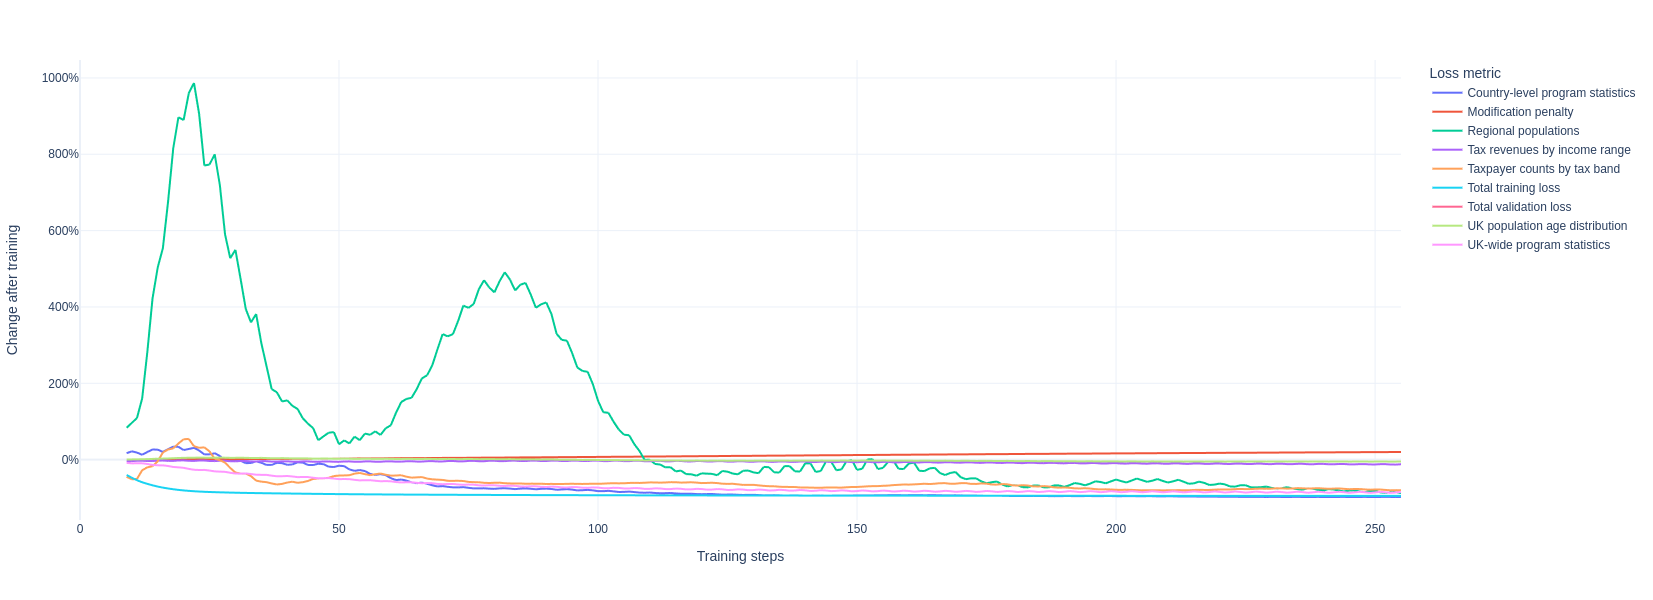

In [1]:
import yaml
from openfisca_uk import REPO

with open(REPO / "calibration" / "losses.yaml", "r") as f:
    losses = yaml.safe_load(f)

component_cols = [
    col
    for col in losses
    if col not in ("Total training loss", "Total validation loss")
]
import numpy as np

for col in component_cols:
    arr = np.array(losses[col])
    losses[col] = arr[:2048].reshape((8, 256)).mean(axis=0)

import pandas as pd
import plotly.express as px

df = pd.DataFrame(losses)

px.line(df.rolling(10).mean() / df.iloc[0] - 1, y=df.columns).update_layout(
    template="plotly_white",
    legend_title="Loss metric",
    yaxis_tickformat=".0%",
    width=800,
    height=600,
    yaxis_title="Change after training",
    xaxis_title="Training steps",
)

## Loss characteristic by training epoch

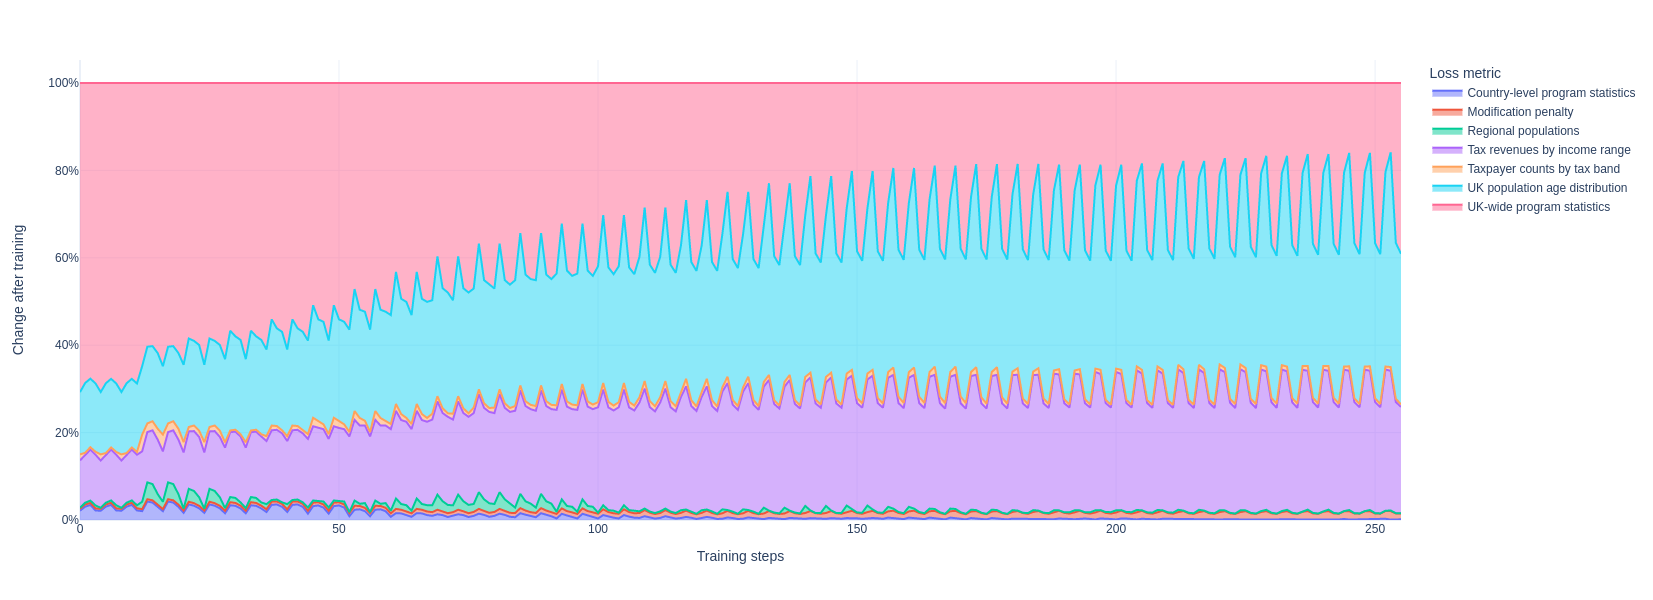

In [2]:
px.area(
    (df.rolling(1).mean().T / df[component_cols].sum(axis=1)).T,
    y=component_cols,
).update_layout(
    template="plotly_white",
    legend_title="Loss metric",
    yaxis_tickformat=".0%",
    width=800,
    height=600,
    yaxis_title="Change after training",
    xaxis_title="Training steps",
)

## Changes to distributions

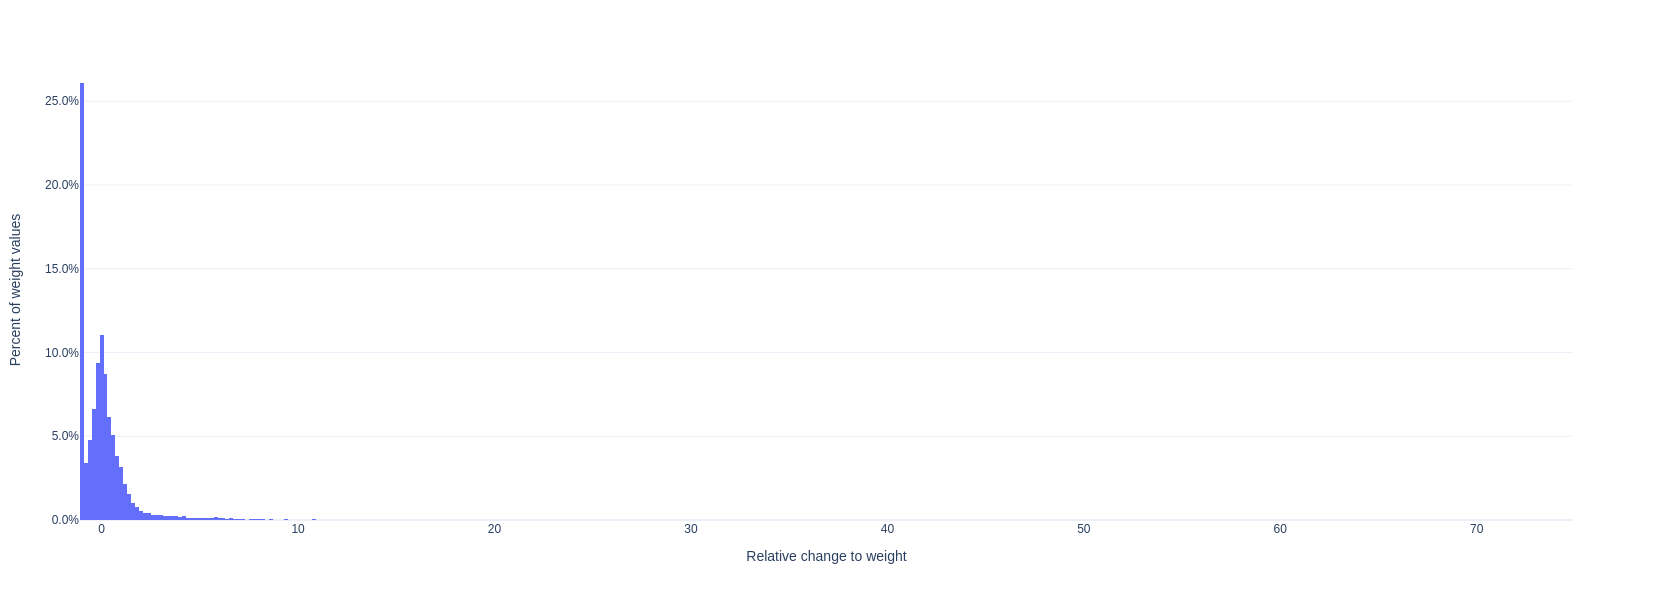

In [3]:
from openfisca_uk import Microsimulation

original = (
    Microsimulation(adjust_weights=False, duplicate_records=2)
    .calc("household_weight", 2022)
    .values
)
reweighted = Microsimulation().calc("household_weight", 2022).values

results = pd.DataFrame(
    dict(
        weight=reweighted / original - 1,
    )
)

weights = results.weight

px.histogram(
    x=results.weight, histnorm="probability", nbins=400
).update_layout(
    template="plotly_white",
    legend_title="Source",
    yaxis_tickformat=".1%",
    width=800,
    height=600,
    yaxis_title="Percent of weight values",
    xaxis_title="Relative change to weight",
)

In [4]:
print(
    f"The above histogram shows the distribution of changes to weights. Around {(weights <= -1).mean():.0%} of the original dataset is dropped: this does not mean that every value provided by those households is untrustworthy - rather, it implies that the error introduced by this household contaminating the dataset with any incorrect information outweighs the benefits that the household can provide over the other households by adding an additional data point. The maximum relative increase to weights is a {weights.max():.0f}-factor increase, and {(weights > 0).mean():.0%} of the households see their weight decrease."
)

The above histogram shows the distribution of changes to weights. Around 24% of the original dataset is dropped: this does not mean that every value provided by those households is untrustworthy - rather, it implies that the error introduced by this household contaminating the dataset with any incorrect information outweighs the benefits that the household can provide over the other households by adding an additional data point. The maximum relative increase to weights is a 75-factor increase, and 44% of the households see their weight decrease.
